Step by step Potato Disease Classification using deep learning

In [1]:
# Import all the Dependencies
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Data collection

In [2]:
# Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) 
# it will show 68 because all the element in the dataset are batch of 32(68*32)

68

Visualize some of the images from our dataset

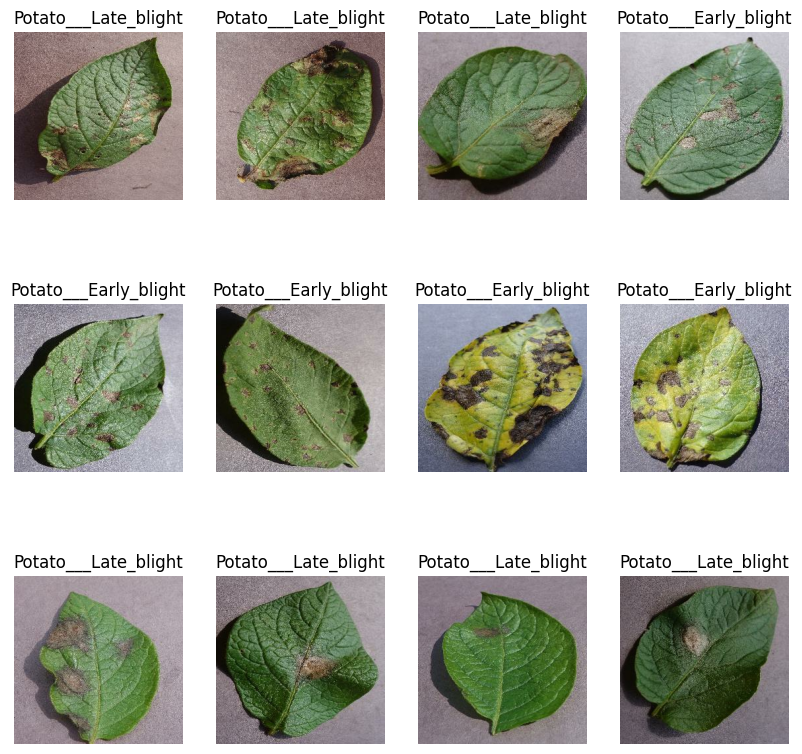

In [6]:
plt.figure(figsize=(10, 10)) # For size of each image
for image_batch, labels_batch in dataset.take(1): #It will take first 32 images
    # we take 12 images from first batch and print the image and label according to that image
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Data Preprocessing

In [7]:
# Function to Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(test_ds)

8

In [11]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model
###### Creating a Layer for Resizing and Normalization

In [12]:
resize_and_rescale = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  keras.layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation
###### Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [13]:
data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Model Architecture
###### We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

Compiling the Model

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20


54/54 [==============================] - 189s 3s/step - loss: 0.8642 - accuracy: 0.5822 - val_loss: 0.7939 - val_accuracy: 0.6146
Epoch 2/20
54/54 [==============================] - 173s 3s/step - loss: 0.5973 - accuracy: 0.7448 - val_loss: 0.4256 - val_accuracy: 0.7969
Epoch 3/20
54/54 [==============================] - 173s 3s/step - loss: 0.4507 - accuracy: 0.8131 - val_loss: 0.3201 - val_accuracy: 0.8854
Epoch 4/20
54/54 [==============================] - 166s 3s/step - loss: 0.2635 - accuracy: 0.8941 - val_loss: 0.2493 - val_accuracy: 0.9010
Epoch 5/20
54/54 [==============================] - 167s 3s/step - loss: 0.2486 - accuracy: 0.8976 - val_loss: 0.2189 - val_accuracy: 0.8906
Epoch 6/20
54/54 [==============================] - 166s 3s/step - loss: 0.2033 - accuracy: 0.9155 - val_loss: 0.2084 - val_accuracy: 0.9115
Epoch 7/20
54/54 [==============================] - 177s 3s/step - loss: 0.2254 - accuracy: 0.9120 - val_loss: 0.1754 - val_accuracy: 0.9219
Epoch 8/20
54/54 [======

In [18]:
model.evaluate(test_ds)

8/8 [==============================] - 13s 636ms/step - loss: 0.1086 - accuracy: 0.9570


[0.1085706353187561, 0.95703125]

Plot the accuracy and loss graph

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

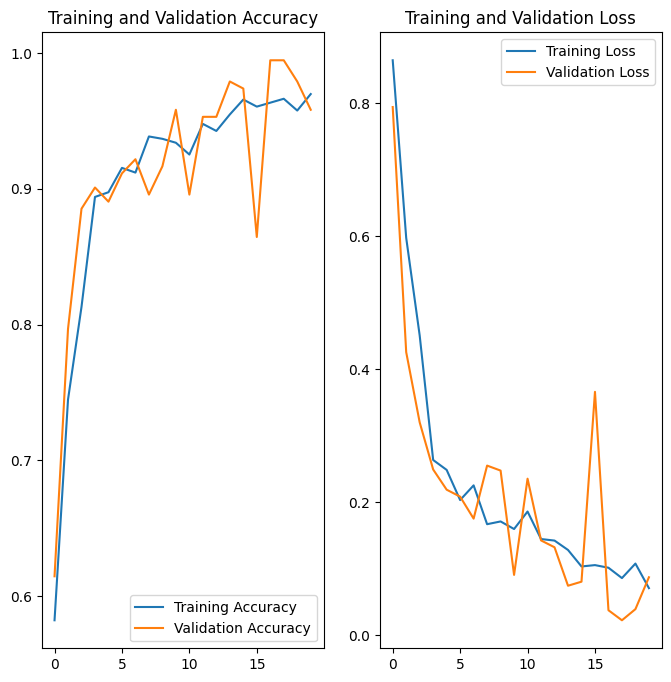

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

actual label: Potato___Late_blight
1/1 [==============================] - 1s 743ms/step
predicted label: Potato___Late_blight


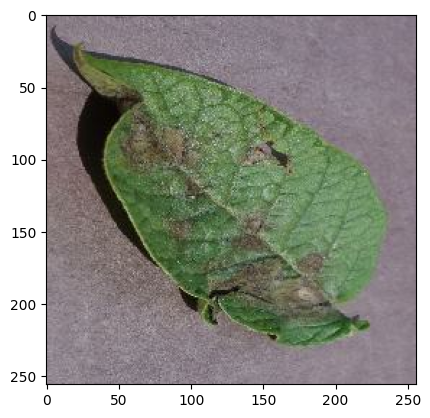

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 50ms/step


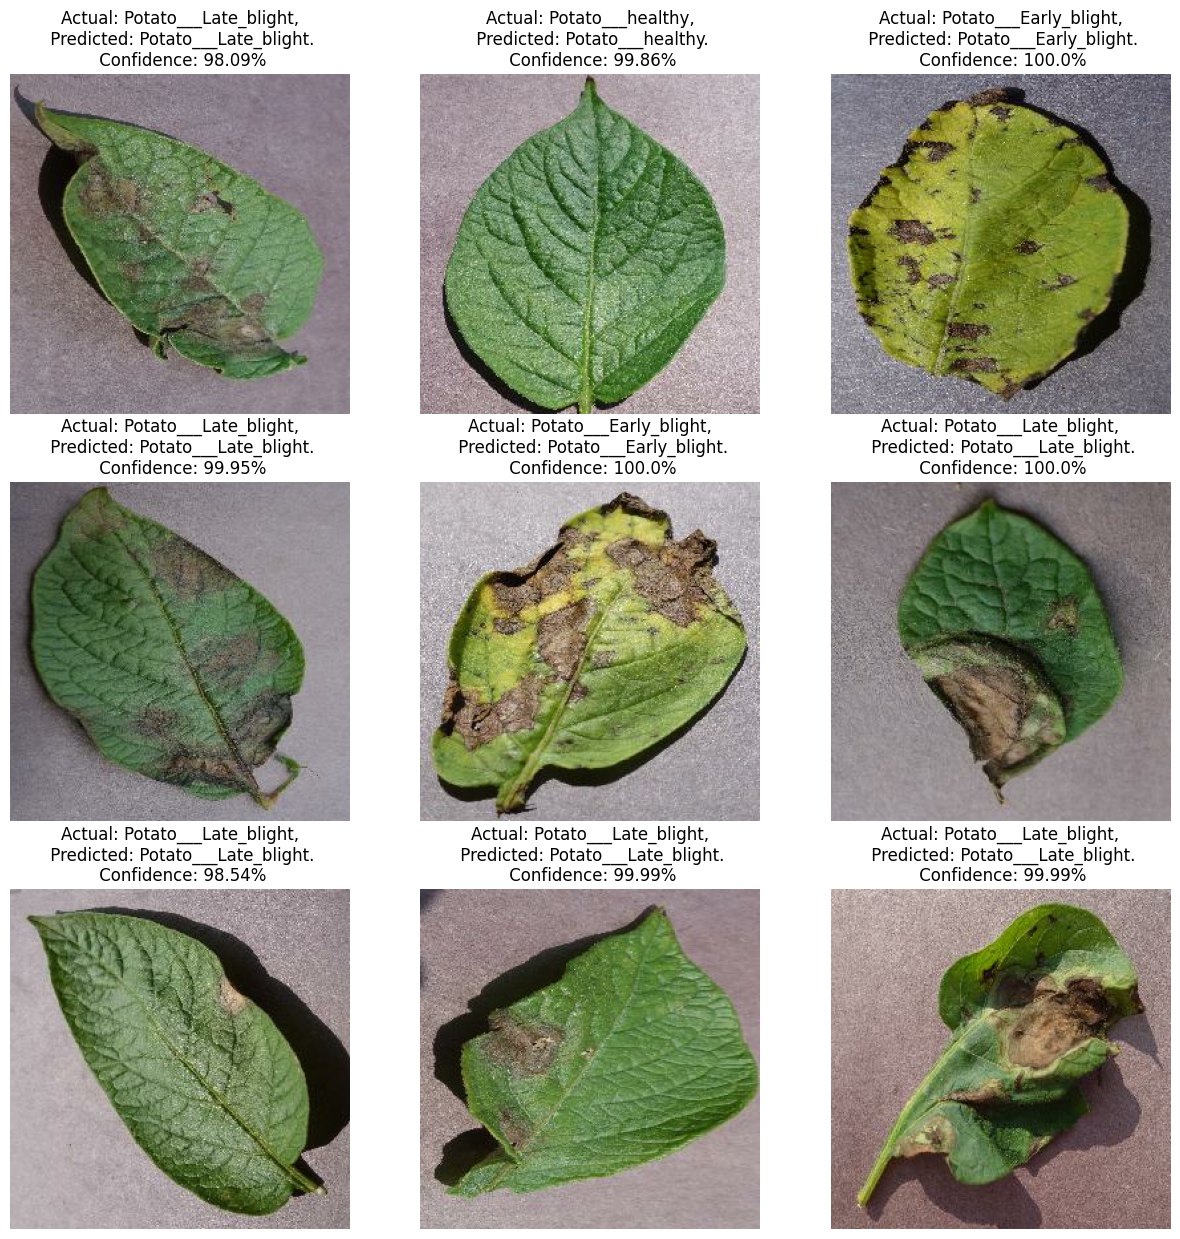

In [26]:
# Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")